This notebook contains implementations of the single-window strong- and weak-constraint 4D-var methods, for the Lorenz-63 dynamical system.

The Lorenz-63 system has 3 variables $x, y, z$, evolving through:

$\frac{dx}{dt} = \sigma(y-x) ; \quad \frac{dy}{dt} = x(r-z)-y ; \quad \frac{dz}{dt} = xy-bz$.

We use the usual parameterisation $\sigma = 10, r=28, b=8/3$.

# Generation of groundtruth data

In [ ]:
import os
import torch
from matplotlib import pyplot as plt
import numpy as np
from time import time
import random as rd
from tensordict import TensorDict
from mdml_sim.lorenz63 import L63Simulator
os.chdir('..')
from da_tools.variational.hard_constraint_4dvar import hc4dvar_single_window
from da_tools.variational.weak_constraint_4dvar import wc4dvar_single_window
from da_tools.system.state import State
from da_tools.observation.operators import random_sparse_noisy_obs, noisy_obs_from_mask
from da_tools.observation.operators import MaskedIidGaussianObsOp, IidGaussianObsOp
from da_tools.util.initialization import naive_initialization
from da_tools.util.visualization import show_1dseqimg
from da_tools.probability.distributions import DiagonalGaussian

First we generate 12K datapoints, by integrating the Lorenz-63 equations with the (default) Runge-Kuntta 4 scheme with a time step of 0.01 s.

In [ ]:
forward_operator = L63Simulator()

initial_state = torch.Tensor([0.1, 0, 0]).reshape((1,3))
ts_length = 12000
time_step = 0.01 # one time step = 0.01 second
forecast_steps = torch.arange(0, ts_length * time_step, time_step)
l63_series = forward_operator.integrate(time=forecast_steps, state=initial_state).squeeze()

The beginning of the time series, highlighted in blue, seems to be away from the stationary regime. Thus, we remove the first 2K steps of data, which results in the second figure.

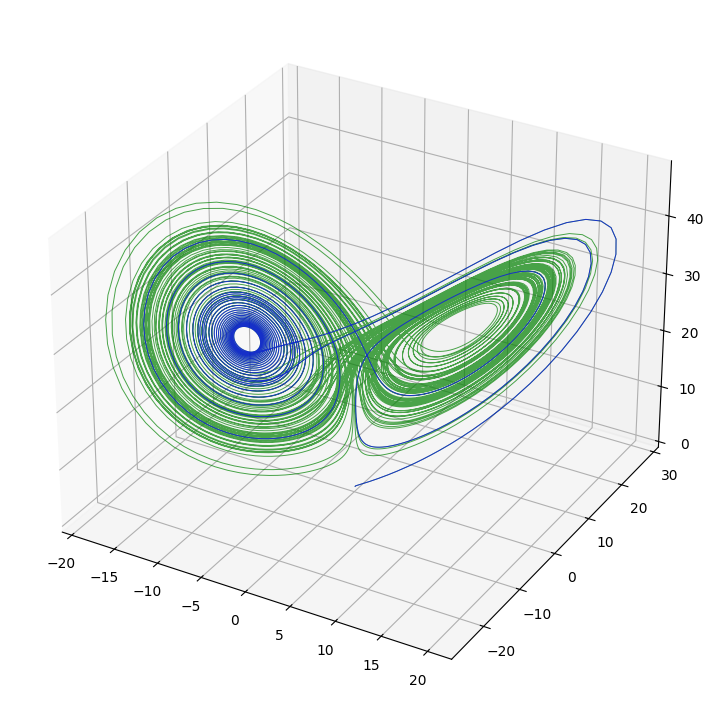

In [ ]:
cutoff = 2000

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(l63_series[:,0], l63_series[:,1], l63_series[:,2], color='g', alpha=0.7, linewidth=0.7)
ax.plot(l63_series[:cutoff,0], l63_series[:cutoff,1], l63_series[:cutoff,2], color='b', alpha=0.7, linewidth=0.7)

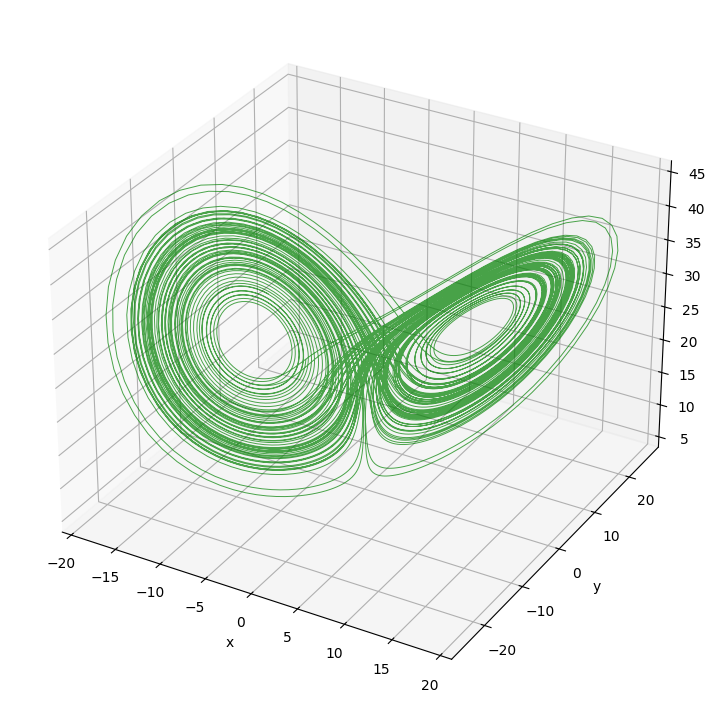

In [ ]:
groundtruth = l63_series[cutoff:]
forecast_steps = forecast_steps[:-cutoff]
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(groundtruth[:,0], groundtruth[:,1], groundtruth[:,2], color='g', alpha=0.7, linewidth=0.7)

Besides the direct 3D visualisation, we can simply plot the evolution of the 3 variables, or a matrix-like representation of their values.

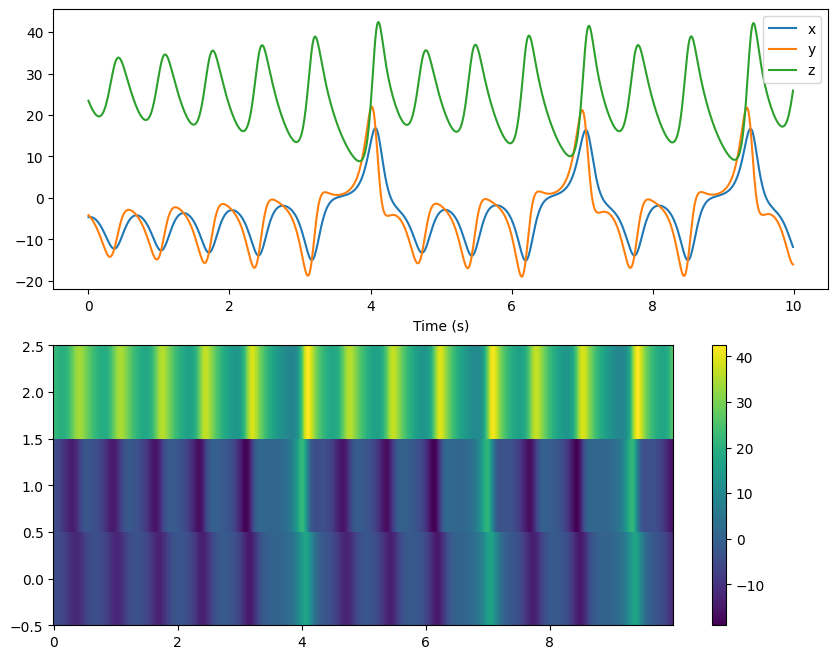

In [ ]:
visu_length = 1000

fig, ax = plt.subplots(2, figsize=(10,8))

times = np.arange(0, visu_length*time_step, time_step)
ax[0].plot(times, groundtruth[:visu_length,0], label='x')
ax[0].plot(times, groundtruth[:visu_length,1], label='y')
ax[0].plot(times, groundtruth[:visu_length,2], label='z')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

show_1dseqimg(groundtruth[:visu_length].T, dt=time_step, ax=ax[1])

# Strong-constraint 4D-var

## Assimilate a noisy trajectory with no missing observations

First, we use our time series tensor and the associated time tensor to instantiate a State object.

In [ ]:
true_ts = State(groundtruth.reshape(1, -1, 3), time_axis=forecast_steps)
print(true_ts)

State(
    Fields: TensorDict(
        fields={
            x: Tensor(shape=torch.Size([1, 10000, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
        batch_size=torch.Size([1, 10000]),
        device=None,
        is_shared=False)
    Time axis: tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 9.9970e+01, 9.9980e+01,
            9.9990e+01]))


Now, let us generate a set of sparse and noisy observations of our groundtruth time series.

We draw straight lines between our sparse observations for easier visualization, but the relevant information is contained in the dots only.

In [ ]:
noise_amplitude = 1 # the standard deviation of the noise is 1
obs_proportion = 1 # all variables are observed

true_ts, obs_op, observations = random_sparse_noisy_obs(true_ts, noise_amplitude, obs_proportion)

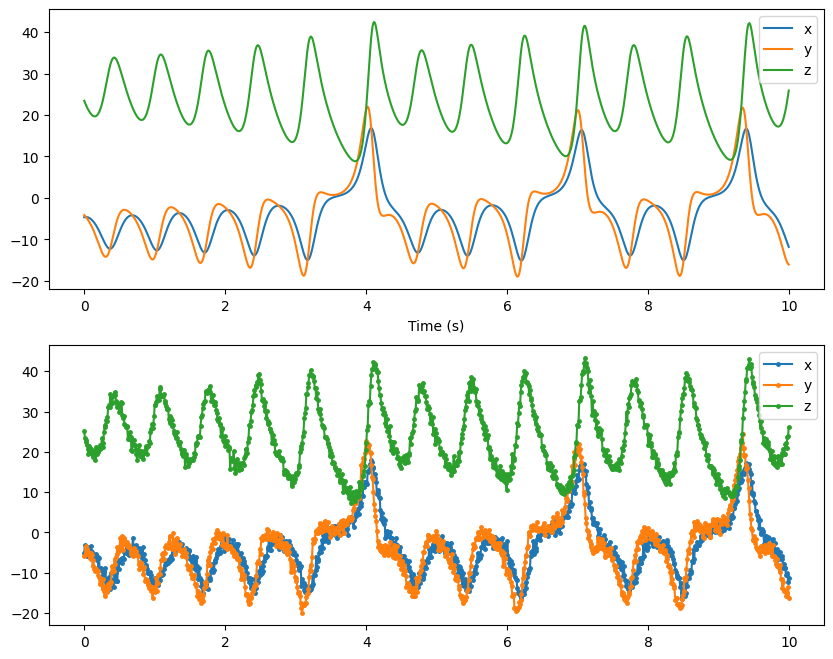

In [ ]:
# Here we show the groundtruth on the top plot and the noisy observations on the bottom plot
fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 0], label='x')
ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 1], label='y')
ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 2], label='z')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

ax[1].plot(observations.mask.time_axis[:visu_length], 
           observations.state.fields['x'][0,:visu_length,0], label='x', marker='.', markersize=5)
ax[1].plot(observations.mask.time_axis[:visu_length], 
           observations.state.fields['x'][0,:visu_length,1], label='y', marker='.', markersize=5)
ax[1].plot(observations.mask.time_axis[:visu_length], 
           observations.state.fields['x'][0,:visu_length,2], label='z', marker='.', markersize=5)
ax[1].legend()

Let us define a simple one-time-step function in order to fit the da-tools conventions
Our 4D-var implementation always requires a function like this taking the state, time increment, dynamic inputs and static inputs (althrough usually not all of these arguments are used in the computations).

In [ ]:
def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    "this time stepping function expects the input State x to have a single field called 'x'"
    B, T = x.fields.batch_size[:2]
    x_tensor = x.fields.reshape(-1)["x"]  # combine batch and time dimensions, leave others intact
    integrated = forward_operator.integrate(torch.arange(2) * dt, x_tensor)[:, 1]
    integrated = integrated.unsqueeze(0)  # re-add batch dimension
    new_fields = TensorDict(x=integrated, batch_size=(1, T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

Let us now build an initial guess for the initial state, using the available observations.
We simply use the first available observation for each channel.

In [ ]:
initialization = naive_initialization(observations)  # state estimate for all time points
initialization = initialization[:, :1]  # first time point only

print(f"Initial guess: {initialization.fields['x'].squeeze()}")
print(f"True initial state: {true_ts.fields['x'].squeeze()[0]}")

Initial guess: tensor([-5.0266, -5.8523, 25.1458])
True initial state: tensor([-4.6594, -4.1334, 23.4386])


In [ ]:
n_obs_steps = 200 # we assimilate only on the earliest time steps, otherwise the optimization would be too unstable
time_window = (observations.state.time_axis[0], observations.state.time_axis[n_obs_steps])

obs_op_opt = obs_op.restrict_time_domain(*time_window)
observations_opt = observations.restrict_time_domain(*time_window)

print(obs_op.mask.fields)

TensorDict(
    fields={
        x: Tensor(shape=torch.Size([1, 10000, 3]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([1, 10000]),
    device=None,
    is_shared=False)


In [ ]:
t0 = time()
assimilated_ic = hc4dvar_single_window(next_step_function, 
                                       observations_opt, 
                                       obs_op_opt, 
                                       initialization,                                        
                                       optimizer_pars={'lr': 1e-1},
                                       verbose=1,
                                       n_steps=5)                                     
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

iteration 0: loss = 4310.85009765625
iteration 0: loss = 4079.1591796875
iteration 0: loss = 2372.6787109375
iteration 0: loss = 1467.5087890625
iteration 0: loss = 1204.42431640625
iteration 0: loss = 1070.294189453125
iteration 0: loss = 976.0071411132812
iteration 0: loss = 904.6163330078125
iteration 0: loss = 849.231201171875
iteration 0: loss = 805.5084228515625
iteration 0: loss = 770.5130004882812
iteration 0: loss = 742.117431640625
iteration 0: loss = 718.7991943359375
iteration 0: loss = 699.4186401367188
iteration 0: loss = 683.154052734375
iteration 0: loss = 669.34130859375
iteration 0: loss = 657.5125122070312
iteration 0: loss = 647.2830810546875
iteration 0: loss = 638.3692626953125
iteration 0: loss = 630.5408325195312
iteration 1: loss = 623.6221923828125
iteration 1: loss = 617.4740600585938
iteration 1: loss = 611.9884033203125
iteration 1: loss = 607.068603515625
iteration 1: loss = 602.6549682617188
iteration 1: loss = 598.688720703125
iteration 1: loss = 595.150

In [ ]:
print(f'True initial state: {groundtruth[0]}')

MSE0 = torch.mean((initialization.fields['x'].squeeze() - groundtruth[0]) **2)
MSE = torch.mean((assimilated_ic.fields['x'].squeeze() - groundtruth[0]) **2)

print(f'Initial guess: {initialization.fields['x'].squeeze()} (MSE = {MSE0})')
print(f'Assimilated state: {assimilated_ic.fields['x'].squeeze().detach()} (MSE = {MSE})')

True initial state: tensor([-4.6594, -4.1334, 23.4386])
Initial guess: tensor([-5.0266, -5.8523, 25.1458]) (MSE = 2.001248359680176)
Assimilated state: tensor([-4.3127, -4.3163, 23.4728]) (MSE = 0.05161670222878456)


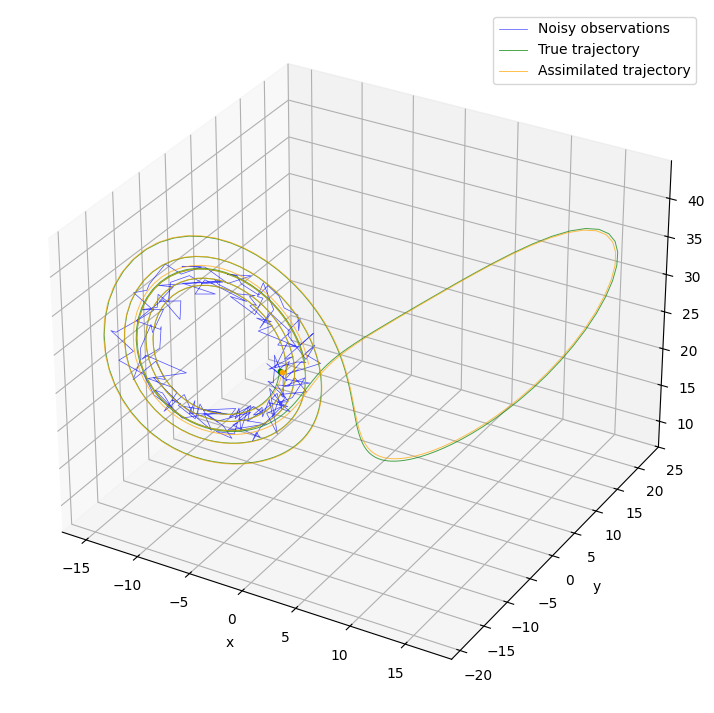

In [ ]:
n_test_steps = 500
assimilated_trajectory = forward_operator.integrate(time=forecast_steps[:n_test_steps], state=assimilated_ic.fields['x'].cpu().detach()).squeeze()

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter([groundtruth[0,0]], [groundtruth[0,1]], [groundtruth[0,2]], c='g', s=10)
ax.scatter([assimilated_trajectory[0,0]], [assimilated_trajectory[0,1]], [assimilated_trajectory[0,2]], c='orange', s=10)
ax.plot(observations.state.fields['x'][0,:n_obs_steps,0], observations.state.fields['x'][0,:n_obs_steps,1], observations.state.fields['x'][0,:n_obs_steps,2], color='b', alpha=0.7, linewidth=0.5, label='Noisy observations')
ax.plot(groundtruth[:n_test_steps,0], groundtruth[:n_test_steps,1], groundtruth[:n_test_steps,2], color='g', alpha=0.7, linewidth=0.7, label='True trajectory')
ax.plot(assimilated_trajectory[:n_test_steps,0], assimilated_trajectory[:n_test_steps,1], assimilated_trajectory[:n_test_steps,2], color='orange', alpha=0.7, linewidth=0.7, label='Assimilated trajectory')
ax.legend()

One can see that the assimilated trajectory fits the true trajectory quite well, even beyond the temporal range of the noisy observations.

## Infer the state of a missing variables

In [ ]:
true_ts = State(groundtruth.reshape(1, -1, 3), time_axis=forecast_steps)

noise_amplitude = 1 # the standard deviation of the noise is 1
mask = torch.ones_like(groundtruth).to(torch.bool)
mask[:, 2] = 0 # we have no observations at all for the last variable z
print(mask)

true_ts, obs_op, observations = noisy_obs_from_mask(true_ts, noise_amplitude, mask)
print(observations.mask.fields['x'])

tensor([[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False],
        ...,
        [ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]])
State(
    Fields: TensorDict(
        fields={
            x: Tensor(shape=torch.Size([1, 10000, 3]), device=cpu, dtype=torch.bool, is_shared=False)},
        batch_size=torch.Size([1, 10000]),
        device=None,
        is_shared=False)
    Time axis: tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 9.9970e+01, 9.9980e+01,
            9.9990e+01]))
tensor([[[ True,  True, False],
         [ True,  True, False],
         [ True,  True, False],
         ...,
         [ True,  True, False],
         [ True,  True, False],
         [ True,  True, False]]])


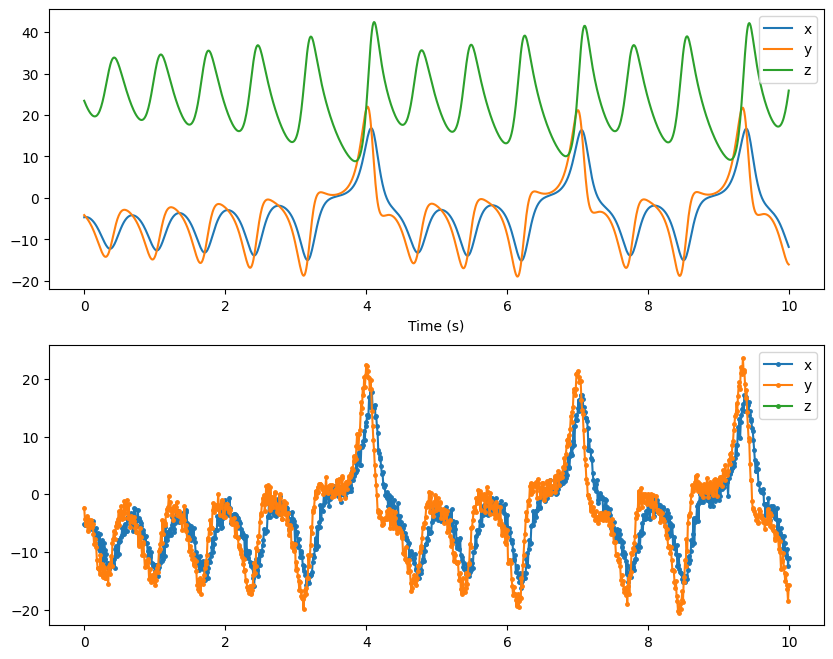

In [ ]:
# Here we show the groundtruth on the top plot and the noisy observations on the bottom plot
fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 0], label='x')
ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 1], label='y')
ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 2], label='z')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

ax[1].plot(observations.mask.time_axis[:visu_length], 
           observations.state.fields['x'][0,:visu_length,0], label='x', marker='.', markersize=5)
ax[1].plot(observations.mask.time_axis[:visu_length], 
           observations.state.fields['x'][0,:visu_length,1], label='y', marker='.', markersize=5)
ax[1].plot(observations.mask.time_axis[:visu_length], 
           observations.state.fields['x'][0,:visu_length,2], label='z', marker='.', markersize=5)
ax[1].legend()

In [ ]:
def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    "this time stepping function expects the input State x to have a single field called 'x'"
    B, T = x.fields.batch_size[:2]
    x_tensor = x.fields.reshape(-1)["x"]  # combine batch and time dimensions, leave others intact
    integrated = forward_operator.integrate(torch.arange(2) * dt, x_tensor)[:, 1]
    integrated = integrated.unsqueeze(0)  # re-add batch dimension
    new_fields = TensorDict(x=integrated, batch_size=(1, T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

In [ ]:
initialization = naive_initialization(observations)  # state estimate for all time points
initialization.fields['x'][:,:,2] = 25 # initialize the unobserved z with roughly its mean value
initialization = initialization[:, :1]  # first time point only

print(f"Initial guess: {initialization.fields['x'].squeeze()}")
print(f"True initial state: {true_ts.fields['x'].squeeze()[0]}")

Initial guess: tensor([-5.1961, -2.3019, 25.0000])
True initial state: tensor([-4.6594, -4.1334, 23.4386])


In [ ]:
n_obs_steps = 200 # we assimilate only on the earliest time steps, otherwise the optimization would be too unstable
time_window = (observations.state.time_axis[0], observations.state.time_axis[n_obs_steps])

obs_op_opt = obs_op.restrict_time_domain(*time_window)
observations_opt = observations.restrict_time_domain(*time_window)

print(obs_op.mask.fields)

TensorDict(
    fields={
        x: Tensor(shape=torch.Size([1, 10000, 3]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([1, 10000]),
    device=None,
    is_shared=False)


In [ ]:
t0 = time()
assimilated_ic = hc4dvar_single_window(next_step_function, 
                                       observations_opt, 
                                       obs_op_opt, 
                                       initialization,                                        
                                       optimizer_pars={'lr': 1e-1},
                                       verbose=1,
                                       n_steps=5)                                     
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

iteration 0: loss = 8309.6162109375
iteration 0: loss = 7514.01611328125
iteration 0: loss = 6456.8740234375
iteration 0: loss = 5589.59716796875
iteration 0: loss = 4861.52880859375
iteration 0: loss = 4241.255859375
iteration 0: loss = 3709.064453125
iteration 0: loss = 3250.354248046875
iteration 0: loss = 2853.99072265625
iteration 0: loss = 2511.216796875
iteration 0: loss = 2214.565673828125
iteration 0: loss = 1958.0238037109375
iteration 0: loss = 1736.3218994140625
iteration 0: loss = 1544.9703369140625
iteration 0: loss = 1380.053955078125
iteration 0: loss = 1238.1802978515625
iteration 0: loss = 1116.3306884765625
iteration 0: loss = 1011.9041137695312
iteration 0: loss = 922.5941162109375
iteration 0: loss = 846.3973388671875
iteration 1: loss = 781.5029296875
iteration 1: loss = 726.3408203125
iteration 1: loss = 679.5703125
iteration 1: loss = 639.9744262695312
iteration 1: loss = 606.5182495117188
iteration 1: loss = 578.2817993164062
iteration 1: loss = 554.51159667968

In [ ]:
print(f'True initial state: {groundtruth[0]}')

MSE0 = torch.mean((initialization.fields['x'].squeeze() - groundtruth[0]) **2)
MSE = torch.mean((assimilated_ic.fields['x'].squeeze() - groundtruth[0]) **2)

print(f'Initial guess: {initialization.fields['x'].squeeze()} (MSE = {MSE0})')
print(f'Assimilated state: {assimilated_ic.fields['x'].squeeze().detach()} (MSE = {MSE})')

True initial state: tensor([-4.6594, -4.1334, 23.4386])
Initial guess: tensor([-5.1961, -2.3019, 25.0000]) (MSE = 2.0267112255096436)
Assimilated state: tensor([-5.6091, -3.6430, 23.2591]) (MSE = 0.39157819747924805)


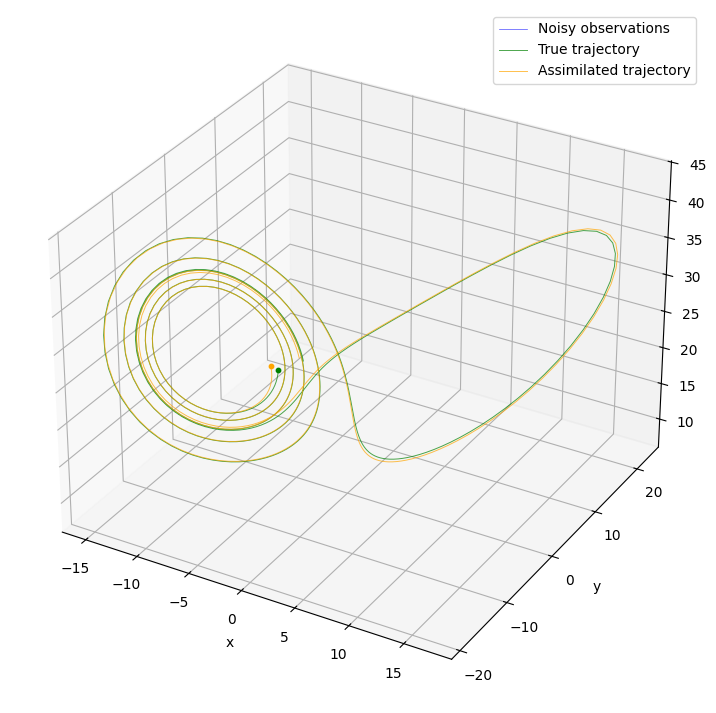

In [ ]:
n_test_steps = 500
assimilated_trajectory = forward_operator.integrate(time=forecast_steps[:n_test_steps], state=assimilated_ic.fields['x'].cpu().detach()).squeeze()

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter([groundtruth[0,0]], [groundtruth[0,1]], [groundtruth[0,2]], c='g', s=10)
ax.scatter([assimilated_trajectory[0,0]], [assimilated_trajectory[0,1]], [assimilated_trajectory[0,2]], c='orange', s=10)
ax.plot(observations.state.fields['x'][0,:n_obs_steps,0], observations.state.fields['x'][0,:n_obs_steps,1], observations.state.fields['x'][0,:n_obs_steps,2], color='b', alpha=0.7, linewidth=0.5, label='Noisy observations')
ax.plot(groundtruth[:n_test_steps,0], groundtruth[:n_test_steps,1], groundtruth[:n_test_steps,2], color='g', alpha=0.7, linewidth=0.7, label='True trajectory')
ax.plot(assimilated_trajectory[:n_test_steps,0], assimilated_trajectory[:n_test_steps,1], assimilated_trajectory[:n_test_steps,2], color='orange', alpha=0.7, linewidth=0.7, label='Assimilated trajectory')
ax.legend()

One can see that it is possible to accurately assimilate a trajectory even when the information on the third variable is entirely missing.

# Weak-constraint 4D-var

Here, we work with the weak-constraint formulation, which means that we allow for deviations of the trajectory from the true dynamical equations, and perform the optimization directly over an entire trajectory rather than only on the initial condition.

In [ ]:
true_ts = State(groundtruth.reshape(1, -1, 3), time_axis=forecast_steps)

noise_amplitude = 2 # the standard deviation of the noise is 2
obs_proportion = 0.25 # only a fraction of the variables are observed

true_ts, obs_op, observations = random_sparse_noisy_obs(true_ts, noise_amplitude, obs_proportion)

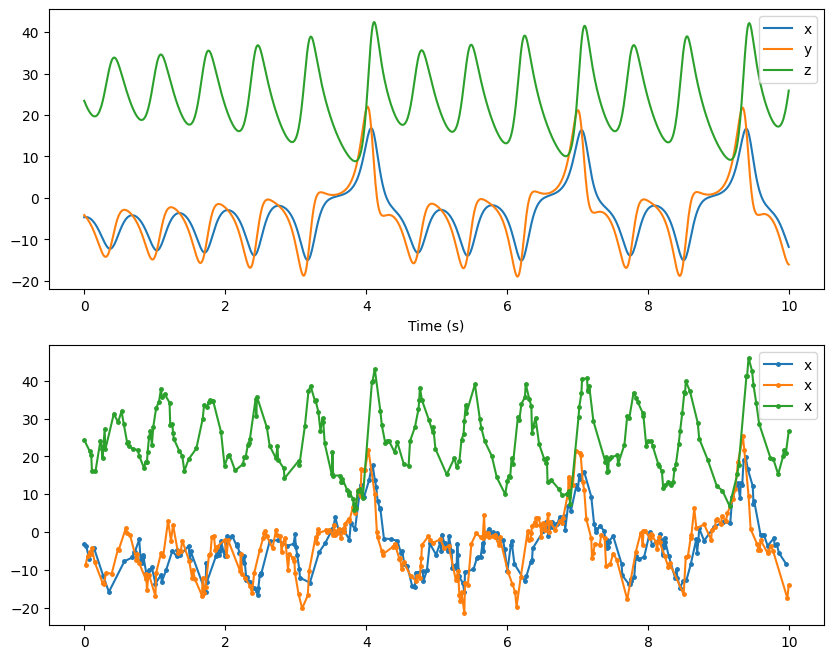

In [ ]:
# Here we show the groundtruth on the top plot and the noisy observations on the bottom plot
fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 0], label='x')
ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 1], label='y')
ax[0].plot(true_ts.time_axis[:visu_length], true_ts.fields['x'][0, :visu_length, 2], label='z')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

ax[1].plot(observations.mask.time_axis[:visu_length][observations.mask.fields['x'][0,:visu_length,0] == 1], 
           observations.state.fields['x'][0,:visu_length,0][observations.mask.fields['x'][0,:visu_length,0] == 1], label='x', marker='.', markersize=5)
ax[1].plot(observations.mask.time_axis[:visu_length][observations.mask.fields['x'][0,:visu_length,1] == 1], 
           observations.state.fields['x'][0,:visu_length,1][observations.mask.fields['x'][0,:visu_length,1] == 1], label='x', marker='.', markersize=5)
ax[1].plot(observations.mask.time_axis[:visu_length][observations.mask.fields['x'][0,:visu_length,2] == 1], 
           observations.state.fields['x'][0,:visu_length,2][observations.mask.fields['x'][0,:visu_length,2] == 1], label='x', marker='.', markersize=5)
ax[1].legend()

In [ ]:
def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    "this time stepping function expects the input State x to have a single field called 'x'"
    B, T = x.fields.batch_size[:2]
    x_tensor = x.fields.reshape(-1)["x"]  # combine batch and time dimensions, leave others intact
    integrated = forward_operator.integrate(torch.arange(2) * dt, x_tensor)[:, 1]
    integrated = integrated.unsqueeze(0)  # re-add batch dimension
    new_fields = TensorDict(x=integrated, batch_size=(1, T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

We build an initial guess for the time series, which simply consists in copying the last available observation for each time and variable.

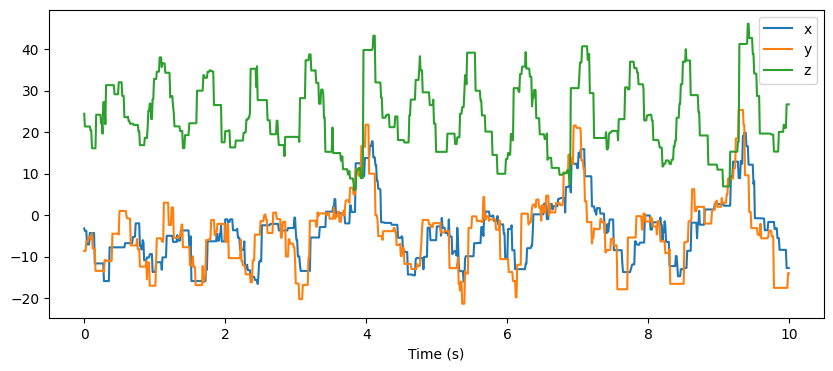

In [ ]:
initialization = naive_initialization(observations)

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(times, initialization.fields['x'][0,:visu_length,0], label='x')
ax.plot(times, initialization.fields['x'][0,:visu_length,1], label='y')
ax.plot(times, initialization.fields['x'][0,:visu_length,2], label='z')
ax.set_xlabel('Time (s)')
ax.legend()

In [ ]:
n_steps = true_ts.time_axis.nelement()

# In addition to strong-constraint 4D-var we now define a distribution on model errors
model_error_distribs = DiagonalGaussian(torch.zeros(1, n_steps-1, 3), 
                                        torch.ones(1, n_steps-1, 3))

In [ ]:
# This should take around a minute to run on a reasonably powerful CPU
t0 = time()
assimilated_states = wc4dvar_single_window(next_step_function, 
                                          observations, 
                                          obs_op, 
                                          model_error_distribs,
                                          x_init=initialization, 
                                          optimizer_pars={'lr': 1},
                                          alpha=1e4,
                                          n_steps=50,
                                          verbose=0)                                       
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

assimilated_states = assimilated_states.detach()

Total time for the 4Dvar optimization: 40.61089062690735 seconds


In [ ]:
print(f'Initial guess MSE: {torch.mean((groundtruth[:n_steps] - initialization.fields['x'][0]) **2)}')
print(f'Assimilated trajectory MSE: {torch.mean((groundtruth[:n_steps] - assimilated_states.fields['x'][0]) **2)}')

Initial guess MSE: 11.062357902526855
Assimilated trajectory MSE: 0.13251842558383942


In the following figure we show on top a part of the groundtruth time series, on the middle the sparse and noisy observations, and on the bottom our assimilated trajectory. The assimilated trajectory appears to be very close to the groundtruth.

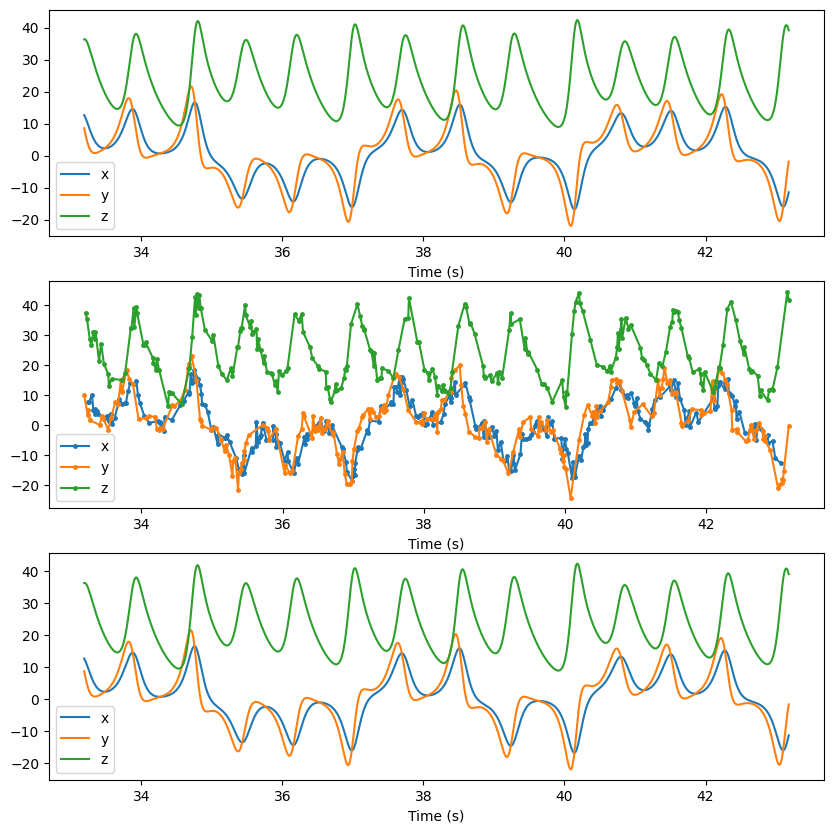

In [ ]:
start_index = rd.randint(0, n_steps - visu_length)
times = forecast_steps[start_index:start_index+visu_length]
mask = observations.mask.fields['x'][0]

fig, ax = plt.subplots(3, figsize=(10,10))

ax[0].plot(times, groundtruth[start_index:start_index+visu_length,0], label='x')
ax[0].plot(times, groundtruth[start_index:start_index+visu_length,1], label='y')
ax[0].plot(times, groundtruth[start_index:start_index+visu_length,2], label='z')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

ax[1].plot(times[mask[start_index:start_index+visu_length,0]==1], 
           observations.state.fields['x'][0,start_index:start_index+visu_length,0][mask[start_index:start_index+visu_length,0]==1], label='x', marker='.', markersize=5)
ax[1].plot(times[mask[start_index:start_index+visu_length,1]==1], 
           observations.state.fields['x'][0,start_index:start_index+visu_length,1][mask[start_index:start_index+visu_length,1]==1], label='y', marker='.', markersize=5)
ax[1].plot(times[mask[start_index:start_index+visu_length,2]==1], 
           observations.state.fields['x'][0,start_index:start_index+visu_length,2][mask[start_index:start_index+visu_length,2]==1], label='z', marker='.', markersize=5)
ax[1].set_xlabel('Time (s)')
ax[1].legend()

ax[2].plot(times, assimilated_states.fields['x'][0,start_index:start_index+visu_length,0].cpu().detach(), label='x')
ax[2].plot(times, assimilated_states.fields['x'][0,start_index:start_index+visu_length,1].cpu().detach(), label='y')
ax[2].plot(times, assimilated_states.fields['x'][0,start_index:start_index+visu_length,2].cpu().detach(), label='z')
ax[2].set_xlabel('Time (s)')
ax[2].legend()

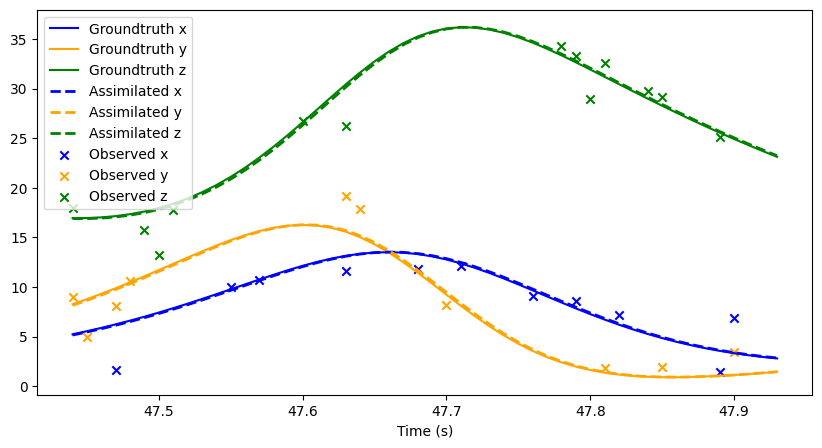

In [ ]:
visu_length_fine = 50
start_index = rd.randint(0, n_steps - visu_length_fine)
times = forecast_steps[start_index:start_index+visu_length_fine]

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(times, groundtruth[start_index:start_index+visu_length_fine,0], c='b', label='Groundtruth x')
ax.plot(times, groundtruth[start_index:start_index+visu_length_fine,1], c='orange', label='Groundtruth y')
ax.plot(times, groundtruth[start_index:start_index+visu_length_fine,2], c='g', label='Groundtruth z')


ax.plot(times, assimilated_states.fields['x'][0,start_index:start_index+visu_length_fine,0].cpu().detach(), 
        c='b', linestyle='--', linewidth=2, label='Assimilated x')
ax.plot(times, assimilated_states.fields['x'][0,start_index:start_index+visu_length_fine,1].cpu().detach(), 
        c='orange', linestyle='--', linewidth=2, label='Assimilated y')
ax.plot(times, assimilated_states.fields['x'][0,start_index:start_index+visu_length_fine,2].cpu().detach(), 
        c='g', linestyle='--', linewidth=2, label='Assimilated z')

ax.scatter(times[mask[start_index:start_index+visu_length_fine,0]==1], 
           observations.state.fields['x'][0,start_index:start_index+visu_length_fine,0][mask[start_index:start_index+visu_length_fine,0]==1], 
           label='Observed x', marker='x', c='b')
ax.scatter(times[mask[start_index:start_index+visu_length_fine,1]==1], 
           observations.state.fields['x'][0,start_index:start_index+visu_length_fine,1][mask[start_index:start_index+visu_length_fine,1]==1], 
           label='Observed y', marker='x', c='orange')
ax.scatter(times[mask[start_index:start_index+visu_length_fine,2]==1], 
           observations.state.fields['x'][0,start_index:start_index+visu_length_fine,2][mask[start_index:start_index+visu_length_fine,2]==1], 
           label='Observed z', marker='x', c='g')

ax.set_xlabel('Time (s)')
ax.legend()

When zooming in, it appears that the assimilated trajectory indeed matches the groundtruth very closely.